In [1]:
!pip install nltk

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
!pip install keras

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '632fdb87-2d5c-4d22-b120-fb1f2a68ecbd'
resource_group = 'Dishant'
workspace_name = 'NLP_Sentiment'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='mydataTweets')
data = dataset.to_pandas_dataframe()

In [7]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [8]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df


def removeStopWords(df, text_field):
    for i in range(len(df)):
        words = word_tokenize(df[text_field][i])
        new = []
        for word in words:
            if word not in stopwords.words('english'):
                new.append(word)
        df[text_field][i] = ' '.join(new)
    return df


def lemmatization(df, text_field):
    lem = WordNetLemmatizer()
    for i in range(len(df)):
        words = word_tokenize(df[text_field][i])
        words = [lem.lemmatize(word,pos='v') for word in words]
        df[text_field][i] = ' '.join(words)
    return df

In [9]:
def preprocessing(df, text_field):
    df_clean = clean_text(df, text_field)
    df_clean = removeStopWords(df_clean, text_field)
    df_clean = lemmatization(df_clean, text_field)
    return df_clean

In [10]:
data_clean = preprocessing(data, "tweet")
data_clean.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cant use cause dont offer wh...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation


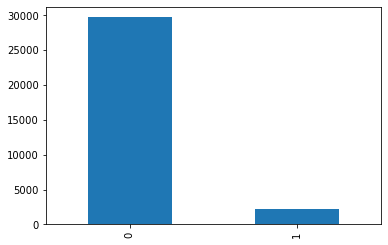

In [11]:
data_clean["label"].value_counts().sort_index().plot.bar()

In [12]:
data_clean["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [13]:
data_clean["tweet"] = data_clean["tweet"].astype(str)

In [14]:
tokenizer = Tokenizer(num_words=7500, split=" ")
tokenizer.fit_on_texts(data_clean["tweet"].values)

X = tokenizer.texts_to_sequences(data_clean["tweet"].values)
X = pad_sequences(X)
X[10:15]

array([[   0,    0,    0,    0,    0,    0,    0, 1113, 2344, 1096, 1699,
         325,  145,  947, 2873, 3111,  181,   76,  104,   98,  132],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 2871,   71, 2682,  670, 2871, 1277, 1057,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    3,   15,  502,   13],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1465,  157, 6660, 1405,  164,  687, 1170, 4699, 1700],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  397, 1097, 1619, 6661, 6661]],
      dtype=int32)

In [15]:
model = Sequential()
model.add(Embedding(7500, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 256)           1920000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,971,138
Trainable params: 2,971,138
Non-trainable params: 0
_________________________________________________________________


In [17]:
y = pd.get_dummies(data_clean['label']).values
[print(data_clean['label'][i], y[i]) for i in range(0,5)]

0 [1 0]
0 [1 0]
0 [1 0]
0 [1 0]
0 [1 0]


[None, None, None, None, None]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
batch_size = 32
epochs = 20

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test), verbose=2)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25569 samples, validate on 6393 samples
Epoch 1/20
 - 71s - loss: 0.1630 - accuracy: 0.9485 - val_loss: 0.1130 - val_accuracy: 0.9615
Epoch 2/20
 - 70s - loss: 0.0900 - accuracy: 0.9699 - val_loss: 0.1274 - val_accuracy: 0.9637
Epoch 3/20
 - 70s - loss: 0.0632 - accuracy: 0.9795 - val_loss: 0.1215 - val_accuracy: 0.9601
Epoch 4/20
 - 70s - loss: 0.0427 - accuracy: 0.9860 - val_loss: 0.1530 - val_accuracy: 0.9523
Epoch 5/20
 - 70s - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.1669 - val_accuracy: 0.9534
Epoch 6/20
 - 70s - loss: 0.0196 - accuracy: 0.9934 - val_loss: 0.2003 - val_accuracy: 0.9637
Epoch 7/20
 - 70s - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.1945 - val_accuracy: 0.9564
Epoch 8/20
 - 70s - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.2862 - val_accuracy: 0.9421
Epoch 9/20
 - 54s - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.2380 - val_accuracy: 0.9559
Epoch 10/20
 - 39s - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.2292 - val_accuracy: 0.9595
Epoch 11/2

In [20]:
predictions = model.predict(X_test)
print(type(predictions))
print(type(y_test))
y_pred = (predictions >0.5)
print(y_pred)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[ True False]
 [ True False]
 [ True False]
 ...
 [ True False]
 [ True False]
 [ True False]]


In [21]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6025
           1       0.62      0.69      0.65       368

   micro avg       0.96      0.96      0.96      6393
   macro avg       0.80      0.83      0.81      6393
weighted avg       0.96      0.96      0.96      6393
 samples avg       0.96      0.96      0.96      6393



In [22]:
print(predictions)
print(y_test)
print(len(predictions))
print(len(y_test))
print(np.argmax(predictions[0]))

[[9.9999988e-01 1.4655687e-07]
 [9.9999988e-01 1.3762650e-07]
 [9.9999952e-01 4.2533949e-07]
 ...
 [9.9999988e-01 1.4939357e-07]
 [9.5003259e-01 4.9967486e-02]
 [9.9999988e-01 1.1127989e-07]]
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]
6393
6393
0


In [23]:
trueValue = 0 
falseValue = 0
for i in range(len(predictions)):
  if np.argmax(predictions[i]) == np.argmax(y_test[i]):
    trueValue += 1
  else:
    falseValue += 1

print(f"True Predictions : {(trueValue/len(predictions))*100}")
print(f"False Predictions : {(falseValue/len(predictions))*100}")

True Predictions : 95.77663068981698
False Predictions : 4.2233693101830125


In [24]:
from sklearn.utils import resample

data_majority = data_clean[data_clean.label==0]
data_minority = data_clean[data_clean.label==1]

data_minority_upsampled = resample(data_minority, 
                                 replace=True,    
                                 n_samples=len(data_majority),   
                                 random_state=123)
data_upsampled = pd.concat([data_minority_upsampled, data_majority])
data_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [25]:
print(data_upsampled.shape)
data_upsampled.head()

(59440, 2)


,label,tweet
19492,1,might libtard libtard sjw liberal politics
16151,1,good place sta learn abt one person amp bigot ...
25144,1,allahsoil bernanke bail wall street dump 600 b...
30902,1,wait somebody call dont see anybody
16522,1,white people expats rest us immigrants socialc...


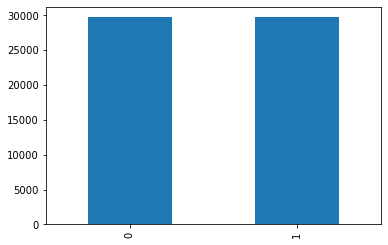

In [26]:
data_upsampled["label"].value_counts().sort_index().plot.bar()

In [27]:
data_upsampled["tweet"] = data_upsampled["tweet"].astype(str)

In [32]:
tokenizer2 = Tokenizer(num_words=7500, split=" ")
tokenizer2.fit_on_texts(data_upsampled["tweet"].values)

X2 = tokenizer.texts_to_sequences(data_upsampled["tweet"].values)
X2 = pad_sequences(X2)
X2[10:15]

array([[   0,    0,    0,    0,    0,    9, 3456, 1027,  411,  771,    9,
        1027,  216,    9, 3456,   10,  771,    9, 6814,  137, 1876],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 3051, 1093, 3662,  805],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  338,  830, 5427,  182],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  442, 1132,  158,  234, 1602, 1967],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  130,  439, 1190,  188, 5629,  158,  557, 2363]],
      dtype=int32)

In [33]:
model_up = Sequential()
model_up.add(Embedding(7500, 256, input_length=X2.shape[1]))
model_up.add(Dropout(0.3))
model_up.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model_up.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model_up.add(Dense(2, activation='softmax'))

In [34]:
model_up.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_up.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 21, 256)           1920000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 256)           525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 2,971,138
Trainable params: 2,971,138
Non-trainable params: 0
_________________________________________________________________


In [35]:
y2 = pd.get_dummies(data_upsampled['label']).values
[print(data_upsampled['label'][i], y2[i]) for i in range(0,5)]

0 [0 1]
0 [0 1]
0 [0 1]
0 [0 1]
0 [0 1]


[None, None, None, None, None]

In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [37]:
batch_size = 32
epochs = 15

model.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size,validation_data=(X_test2, y_test2), verbose=2)

Train on 47552 samples, validate on 11888 samples
Epoch 1/15
 - 71s - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.0155 - val_accuracy: 0.9955
Epoch 2/15
 - 71s - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0173 - val_accuracy: 0.9955
Epoch 3/15
 - 71s - loss: 0.0075 - accuracy: 0.9972 - val_loss: 0.0130 - val_accuracy: 0.9964
Epoch 4/15
 - 71s - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0140 - val_accuracy: 0.9960
Epoch 5/15
 - 72s - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0163 - val_accuracy: 0.9960
Epoch 6/15
 - 73s - loss: 0.0053 - accuracy: 0.9981 - val_loss: 0.0222 - val_accuracy: 0.9950
Epoch 7/15
 - 73s - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.0233 - val_accuracy: 0.9950
Epoch 8/15
 - 73s - loss: 0.0047 - accuracy: 0.9980 - val_loss: 0.0209 - val_accuracy: 0.9954
Epoch 9/15
 - 73s - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.0160 - val_accuracy: 0.9963
Epoch 10/15
 - 72s - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.0212 - val_accuracy: 0.9953
Epoch 11/

In [38]:
predictions = model.predict(X_test)
y_pred = (predictions >0.5)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5972
           1       0.99      0.96      0.98       421

   micro avg       1.00      1.00      1.00      6393
   macro avg       0.99      0.98      0.99      6393
weighted avg       1.00      1.00      1.00      6393
 samples avg       1.00      1.00      1.00      6393



In [40]:
model.save("model.h5")

In [41]:
model_up.save("model_upsampled.h5")